In [18]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

In [19]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import geojson

import matplotlib.cm
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

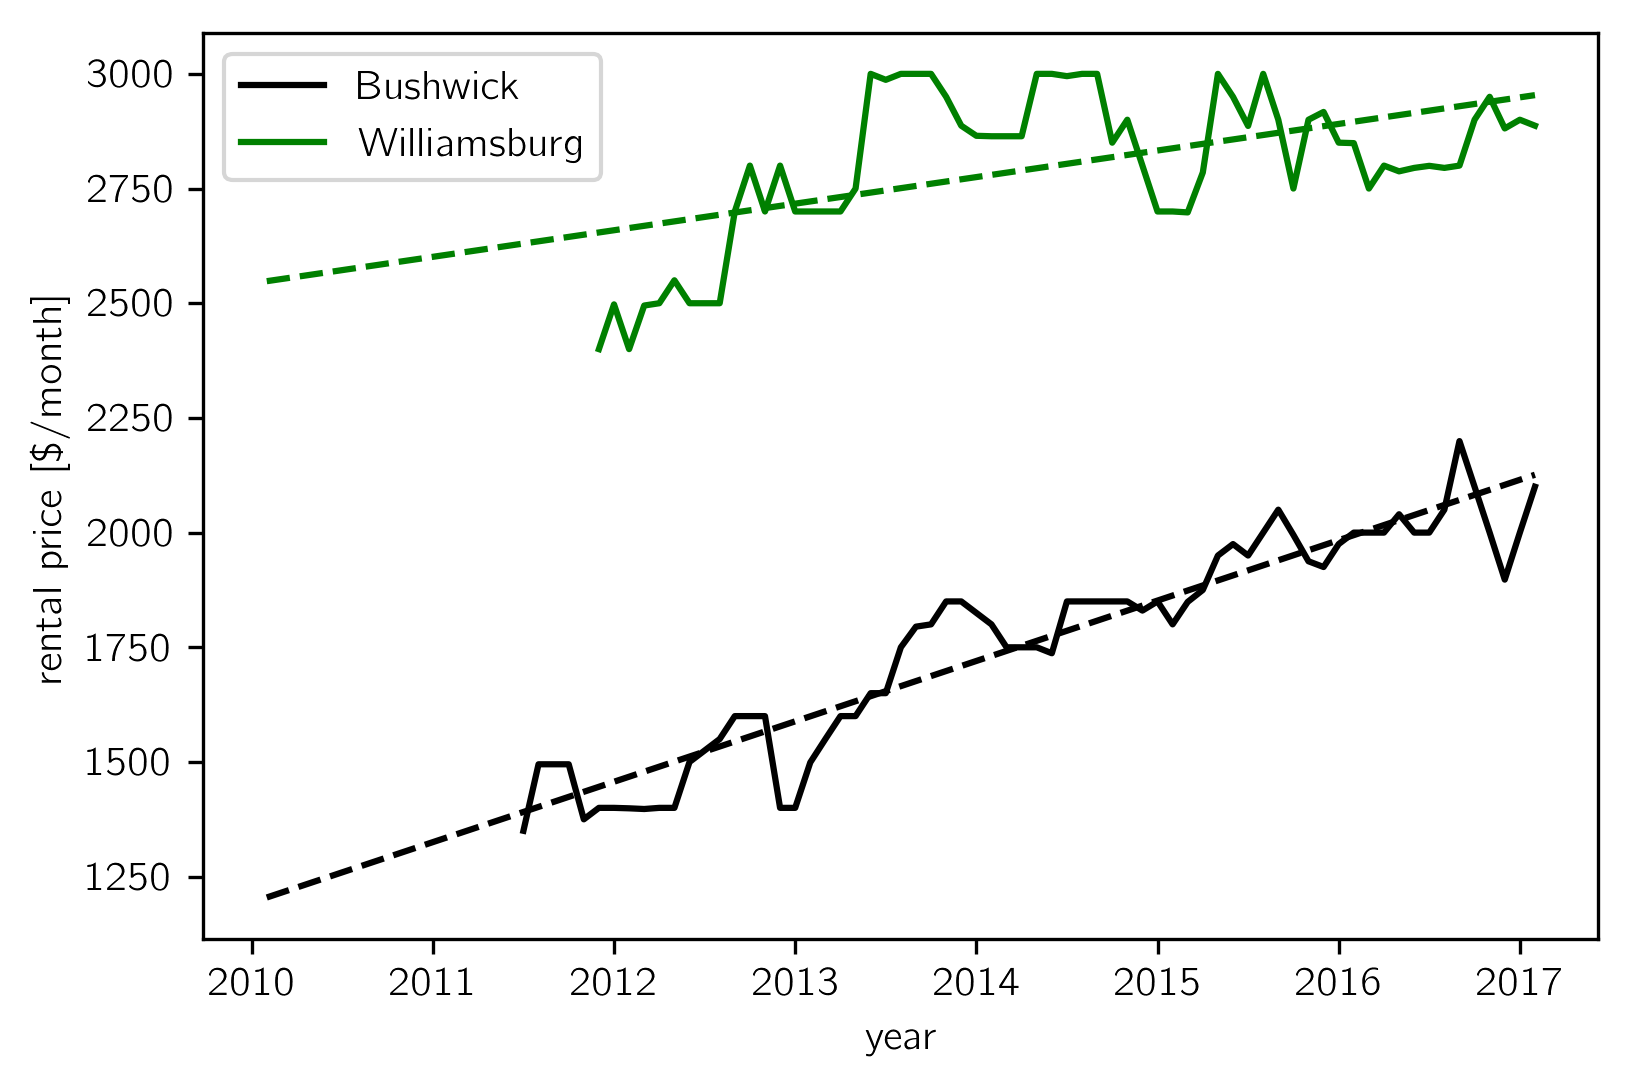

In [100]:
#df = pd.read_csv("http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_Zri_SingleFamilyResidenceRental.csv")
#df = pd.read_csv("http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_MedianRentalPrice_Studio.csv")
df = pd.read_csv("http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_MedianRentalPrice_1Bedroom.csv")
#df = pd.read_csv("http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_MedianRentalPrice_2Bedroom.csv")
#df = pd.read_csv("http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_MedianRentalPrice_3Bedroom.csv")
p = re.compile("([0-9]+)-([0-9]+)")
date_cols = [k for k in df.columns if len(p.findall(k))]
date_num = [list(map(float, p.findall(k)[0])) for k in date_cols]
date_num = [d[0] + (d[1]-1) / 12 for d in date_num]
nyc = df[df.City == "New York"]
neighborhoods = list(nyc.RegionName)
all_price = nyc[date_cols]
mu_price = nyc[date_cols].median()
sig_price = np.sqrt(((nyc[date_cols] - nyc[date_cols].median())**2).median())
norm_price = (all_price - mu_price) / sig_price

# Linear fit
x = np.arange(len(date_cols))
w = np.empty((len(all_price), 2))
for i, y in enumerate(np.array(all_price)):
    m = np.isfinite(y)
    X = np.vander(x[m], 2)
    w[i] = np.array(np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y[m])))

X = np.vander(x, 2)
n = "Bushwick"
ind = neighborhoods.index(n)
color = "k"
plt.plot(date_num, np.array(all_price)[ind], color=color, label=n)
plt.plot(date_num, np.dot(X, w[ind]), "--", color=color)

n = "Williamsburg"
ind = neighborhoods.index(n)
color = "g"
plt.plot(date_num, np.array(all_price)[ind], color=color, label=n)
plt.plot(date_num, np.dot(X, w[ind]), "--", color=color)

plt.legend()
plt.xlabel("year")
plt.ylabel("rental price [\$/month]")

In [101]:
cds = pd.read_csv("data/CB_NewYorkCity.csv", encoding="latin")
mapper = {"Manhattan": 1, "Bronx": 2, "Brooklyn": 3, "Queens": 4, "StatenÊIsland": 5}
cd_to_neighborhoods = dict()
for _, row in cds.iterrows():
    id_ = row["Community Board (CB)"].split("ÊCBÊ")
    cd_to_neighborhoods["{0}{1:02d}".format(mapper[id_[0]], int(id_[1]))] = [
        n.strip() for n in row["Neighborhoods"].split(",")
    ]
neighborhoods_to_cd = dict((n, k) for k, v in cd_to_neighborhoods.items() for n in v)

In [102]:
f = geojson.load(open("data/Community Districts.geojson"))
names = [feat["properties"]["boro_cd"].strip() for feat in f["features"] for shape in feat["geometry"]["coordinates"]]
coords = [np.array(shape[0]) for feat in f["features"] for shape in feat["geometry"]["coordinates"]]
coords = [c for n, c in zip(names, coords) if not n.startswith("5")]
names = [n for n in names if not n.startswith("5")]
lat = np.concatenate([c[:, 1] for c in coords])
lng = np.concatenate([c[:, 0] for c in coords])

In [103]:
def get_best_cd(name):
    for k, cd in neighborhoods_to_cd.items():
        if name.lower() in k.lower():
            return cd
hood_to_cds = dict((n, get_best_cd(n)) for n in neighborhoods if get_best_cd(n) is not None)

In [104]:
counts = np.zeros(len(names))
growth = np.zeros(len(names))
base = np.zeros(len(names))

for i, n in enumerate(neighborhoods):
    cd = hood_to_cds.get(n.strip(), None)
    if cd is None:
        continue
    for ind, cdname in enumerate(names):
        if cd != cdname:
            continue
        growth[ind] += w[i, 0]
        base[ind] += w[i, 1]
        counts[ind] += 1

m = counts > 0
growth[m] /= counts[m]
base[m] /= counts[m]
growth[~m] = np.nan
base[~m] = np.nan

In [105]:
def make_plot(values, title):
    df_poly = pd.DataFrame({
        'poly': [Polygon(c, True, edgecolor="k") for c in coords],
        'label': names,
        'count': values,
    })
    # df_poly = df_poly[df_poly.label.isin(["Williamsburg", "Greenpoint"])]
    df_poly = df_poly[~df_poly.label.str.startswith("5")]
    has_data = df_poly[~df_poly["count"].isnull()]

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    pc = PatchCollection(has_data.poly, zorder=2)
    cmap = plt.get_cmap('Oranges')   
    norm = Normalize()
    pc.set_facecolor(cmap(norm(has_data['count'].fillna(0).values)))
    pc.set_edgecolor("none")
    ax.add_collection(pc)

    mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    mapper.set_array(has_data['count'])
    cbar = fig.colorbar(mapper, label=title)

    pc = PatchCollection(df_poly.poly, zorder=2)
    pc.set_edgecolor("#222222")
    pc.set_facecolor("none")
    pc.set_linewidth(0.5)
    ax.add_collection(pc)

    ax.set_xlim(lng.min(), lng.max())
    ax.set_ylim(lat.min(), lat.max())
    plt.axis("off");

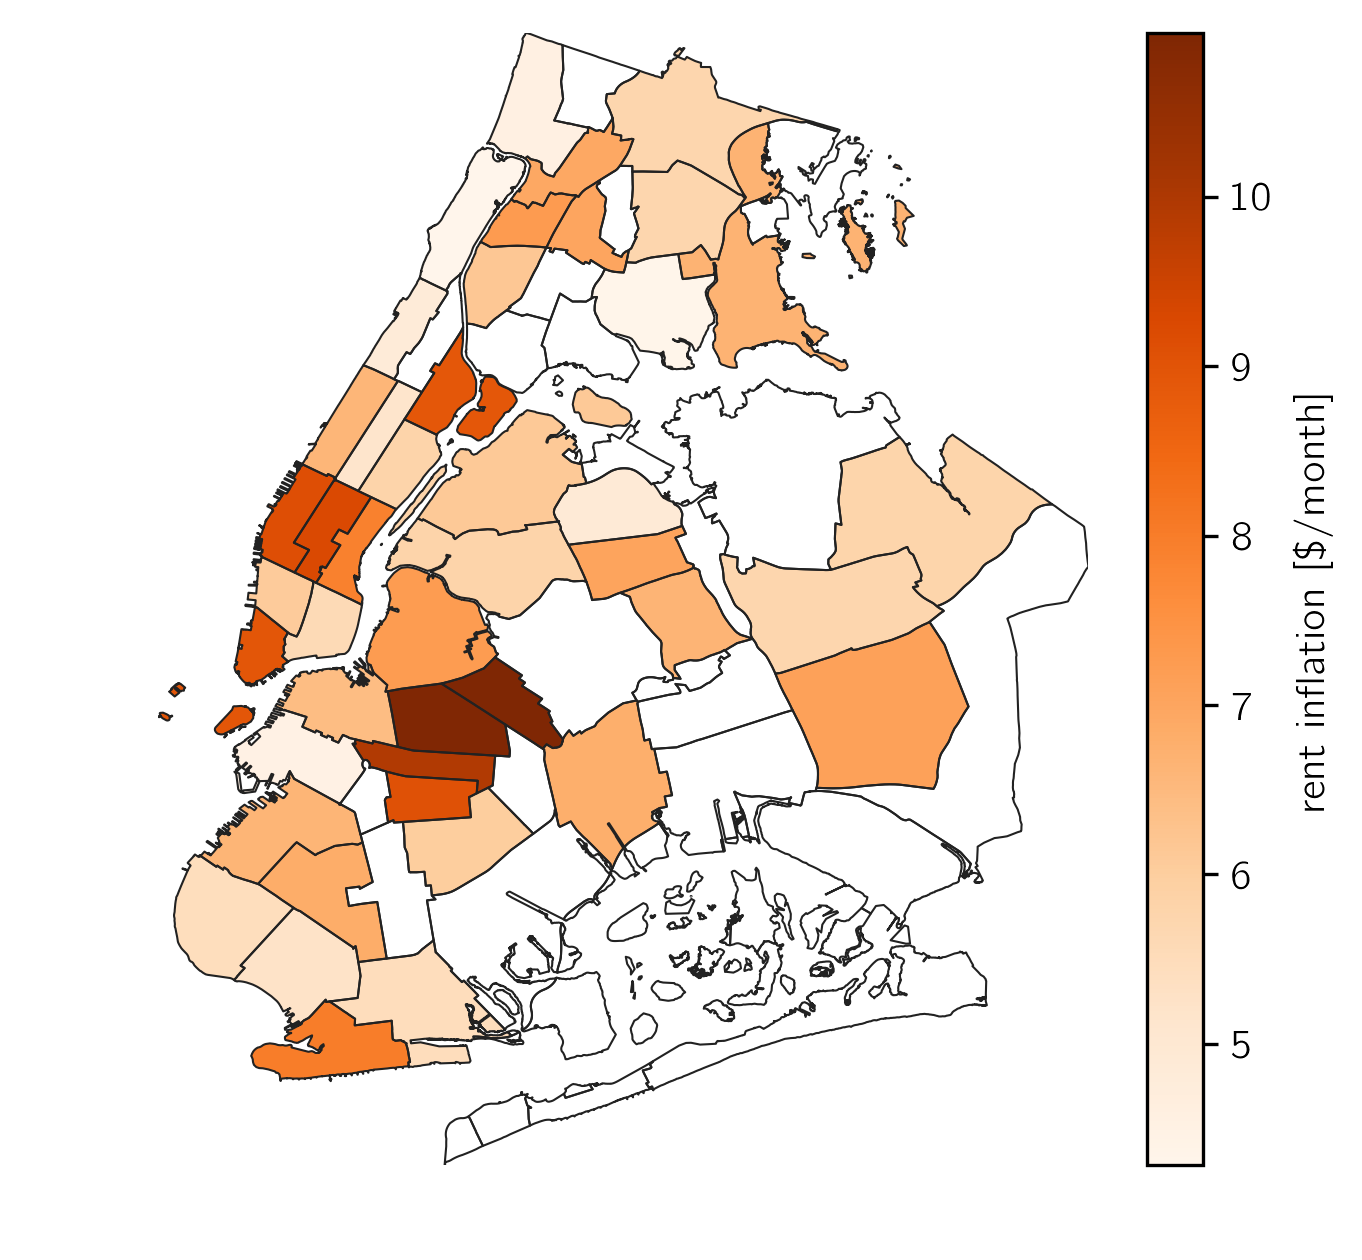

In [106]:
make_plot(growth, "rent inflation [\$/month]")

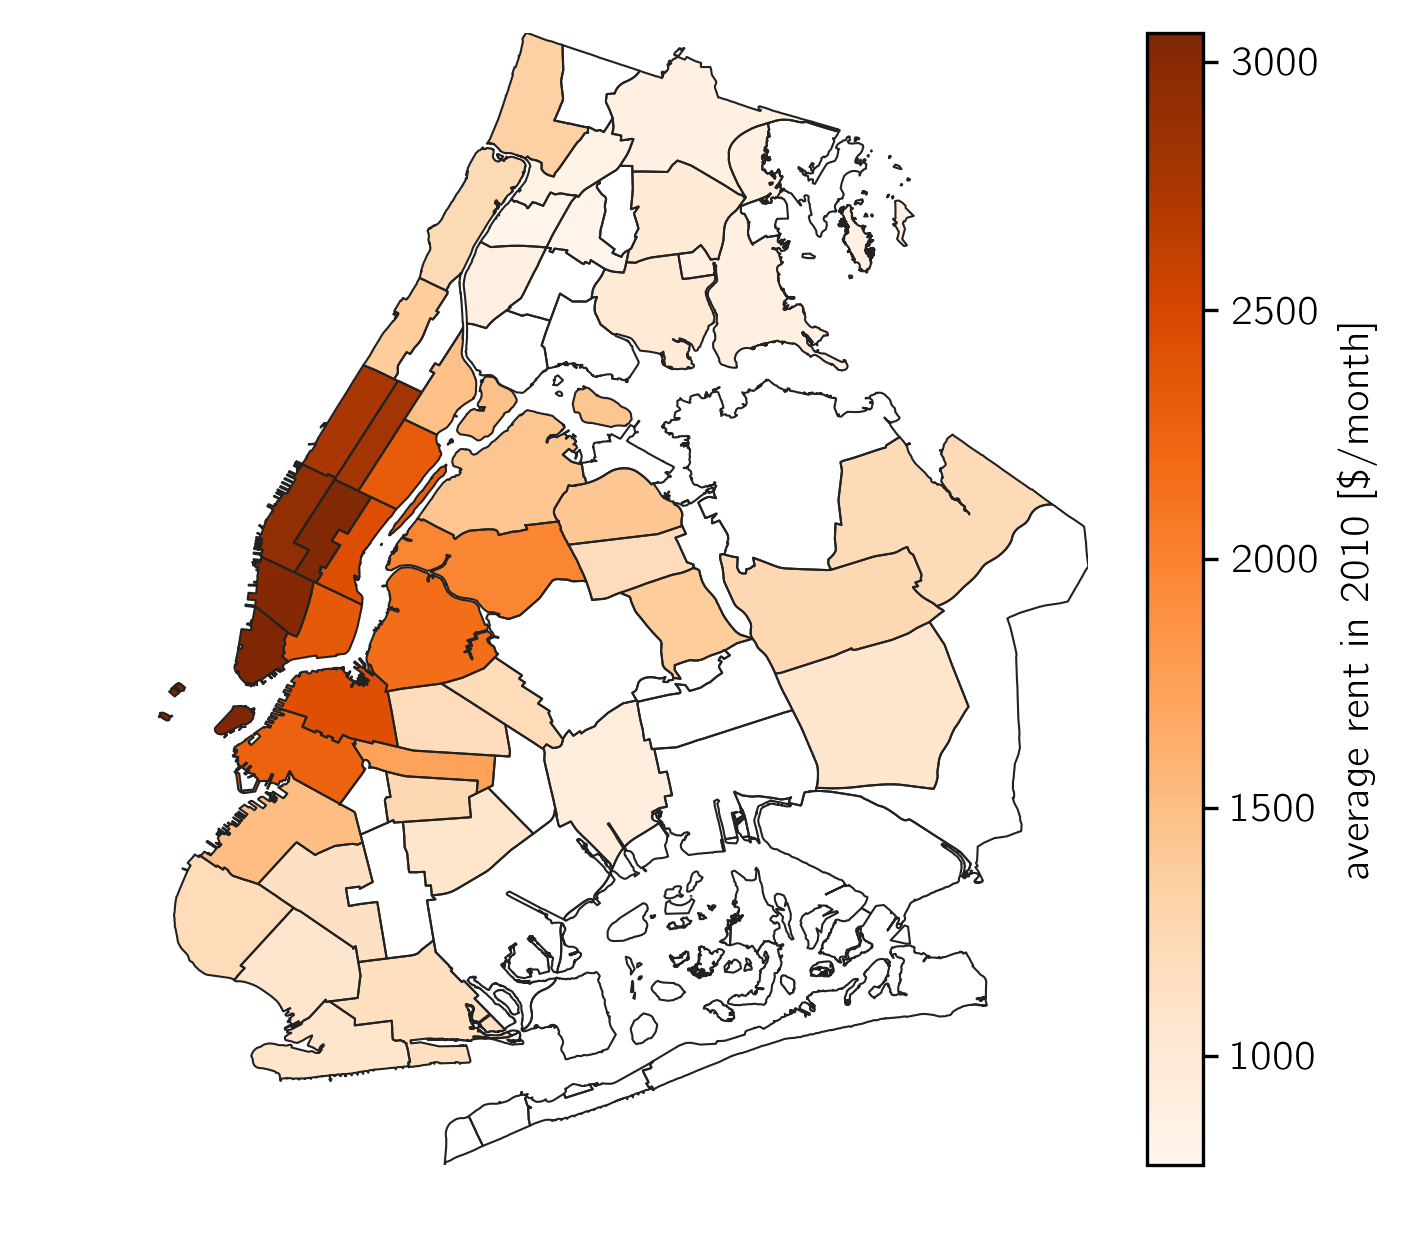

In [107]:
make_plot(base, "average rent in {0:.0f} [\$/month]".format(date_num[0]))